<a href="https://colab.research.google.com/github/knotseaborg/Machine-Learning-Projects/blob/master/Batch_Normalization_and_Dropout_demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Batch Normalization and Dropout

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import seaborn as sns

In [0]:
transforms_train = transforms.Compose([
    transforms.ToTensor(),
])

In [0]:
trainset = torchvision.datasets.MNIST(download = True,
                                     root = "./data",
                                     train = True,
                                     transform = transforms_train)

0it [00:00, ?it/s]

9920512it [00:02, 4589504.73it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 68231.93it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1128374.05it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 25689.95it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)

print(labels.shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([4])
2


In [0]:
def imshow(image, title):
  image = np.transpose(image.numpy(), (1,2,0))
  plt.figure(figsize=(batch_size*4,4))
  plt.imshow(image)
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images, labels = iter(dataloader).next()
  img = torchvision.utils.make_grid(images)
  
  imshow(img, [str(n.item()) for n in labels])

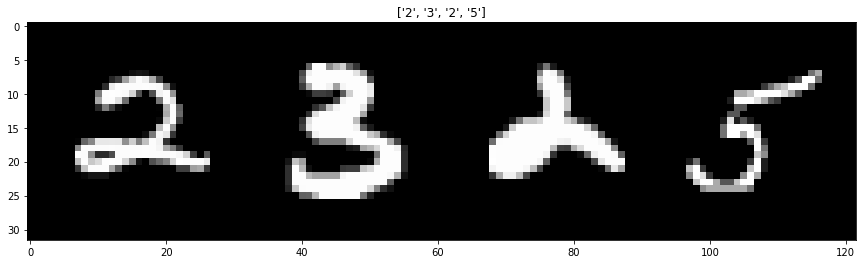

In [0]:
show_batch_images(trainloader)

In [0]:
class MyNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(
        nn.Linear(28*28, 48),
        nn.ReLU(),
        nn.Linear(48, 24),
        nn.ReLU(),
        nn.Linear(24,10)
    )
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.classifier(x)
    return x

In [0]:
class MyNetBN(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(
        nn.Linear(28*28, 48),
        nn.BatchNorm1d(48),
        nn.ReLU(),
        nn.Linear(48, 24),
        nn.BatchNorm1d(24),
        nn.ReLU(),
        nn.Linear(24,10)
    )
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.classifier(x)
    return x

In [0]:
model = MyNet()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [0]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [0]:
batch_size = 512

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [0]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr = 0.01)
opt_bn = torch.optim.SGD(model_bn.parameters(), lr = 0.01)

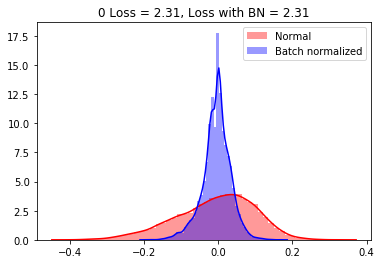

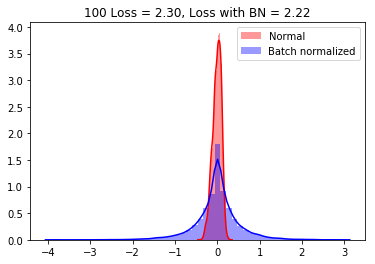

----------------


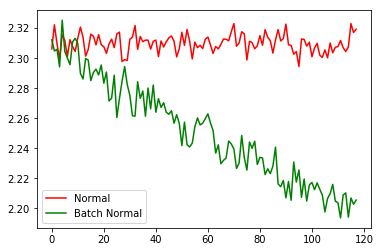

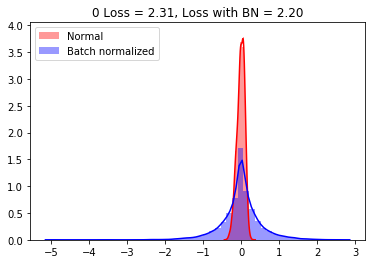

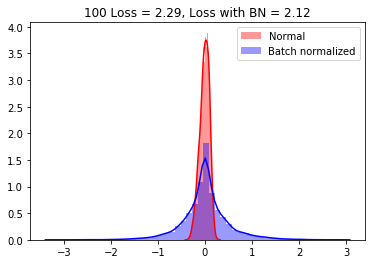

----------------


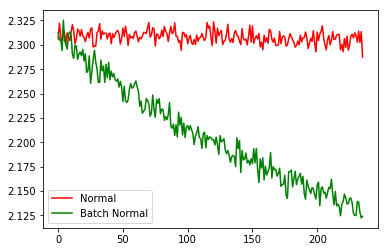

In [0]:
loss_arr = []
loss_arr_bn = []
max_epochs = 2

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    
    opt.zero_grad()
    
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    opt_bn.zero_grad()
    outputs_bn = model_bn(inputs)
    loss_bn = loss_fn(outputs_bn, labels)
    loss_bn.backward()
    opt_bn.step()
    
    loss_arr.append(loss.item())
    loss_arr_bn.append(loss_bn.item())
    
    if i%100 == 0:
      inputs = inputs.view(inputs.shape[0], -1)
      
      model.eval()
      model_bn.eval()
      
      a = model.classifier[0](inputs)
      a = model.classifier[1](a)
      a = model.classifier[2](a)
      a = a.detach().numpy().ravel()
      sns.distplot(a, kde = True, color = 'r', label = "Normal")
      
      b = model_bn.classifier[0](inputs)
      b = model_bn.classifier[1](b)
      b = model_bn.classifier[2](b)
      b = model_bn.classifier[3](b)
      b = model_bn.classifier[4](b)
      b = b.detach().numpy().ravel()
      sns.distplot(b, kde = True, color = 'b', label = "Batch normalized")
      
      plt.title("%d Loss = %0.2f, Loss with BN = %0.2f"%(i,loss, loss_bn))
      plt.legend()
      plt.show()
      plt.pause(0.5)
      
      model.train()
      model_bn.train()
      
  print("----------------")
  plt.plot(loss_arr, 'r', label = "Normal")
  plt.plot(loss_arr_bn, 'g', label = "Batch Normal")
  plt.legend()
  plt.show()
  

##Dropout

In [0]:
N = 25
noise = 0.3

In [0]:
print(torch.linspace(-1, 1, N).shape)
X_train = torch.unsqueeze(torch.linspace(-1, 1, N), dim = 1)
print(X_train.shape)

torch.Size([25])
torch.Size([25, 1])


In [0]:
torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

tensor([[ 0.1409],
        [ 1.0490],
        [-0.5457],
        [ 1.5255],
        [ 1.3646],
        [ 1.9694],
        [-0.6103],
        [ 0.9179],
        [-0.5378],
        [ 0.6628],
        [-0.5619],
        [-0.6016],
        [ 1.1295],
        [ 0.8464],
        [-1.3791],
        [-1.0330],
        [ 1.1918],
        [ 0.8537],
        [ 1.2131],
        [ 0.1135],
        [ 1.1256],
        [ 1.1614],
        [ 0.5106],
        [ 0.2454],
        [-0.2906]])

In [0]:
X_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_train = X_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

X_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_test = X_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

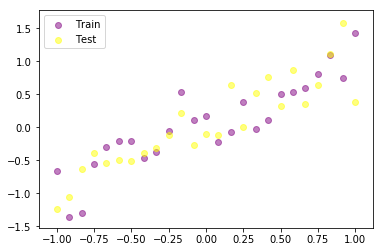

In [0]:
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label = 'Train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha = 0.5, label = "Test")
plt.legend()
plt.show()

In [0]:
N_h = 100

model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.8),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.8),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

In [0]:
opt = torch.optim.Adam(model.parameters(), lr = 0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr = 0.01)
loss_fn = torch.nn.MSELoss()

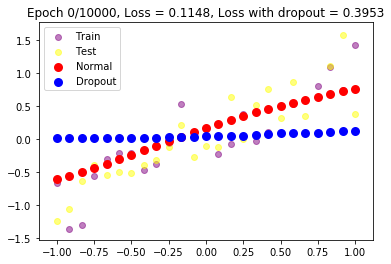

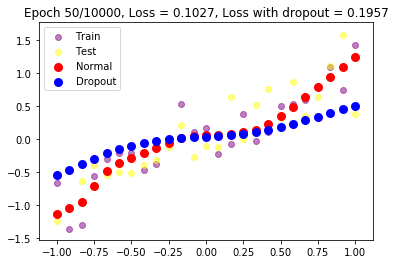

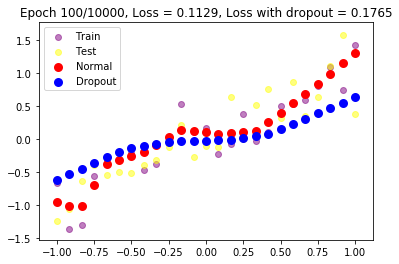

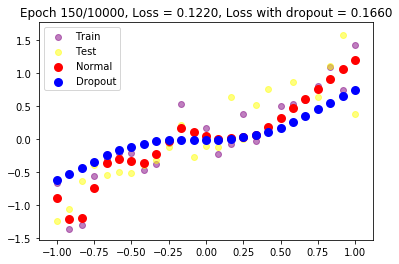

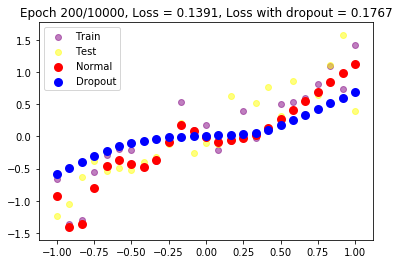

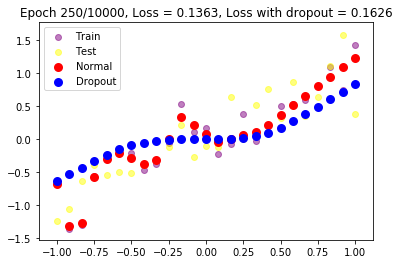

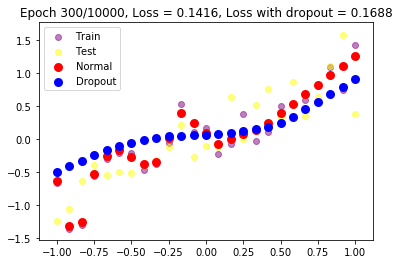

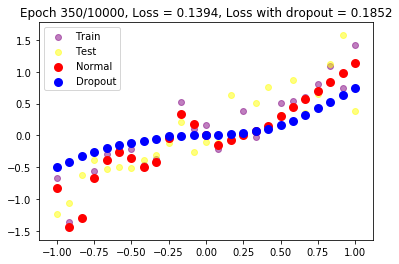

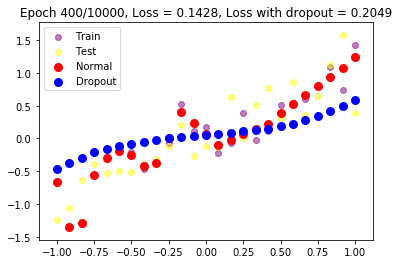

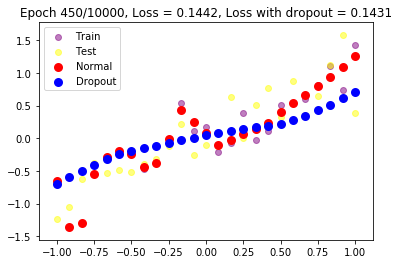

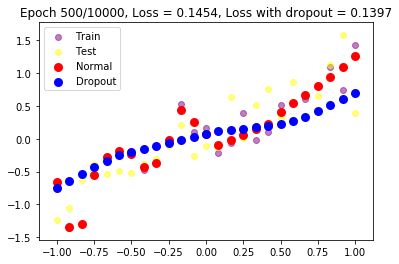

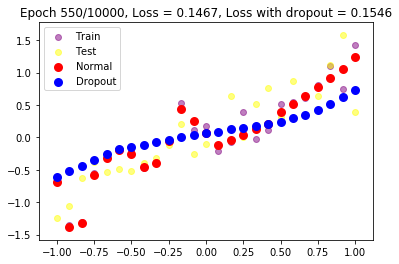

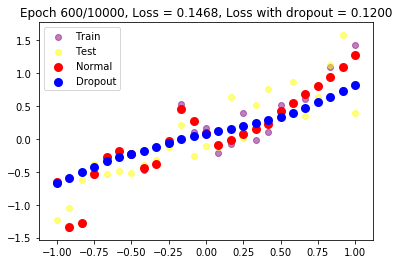

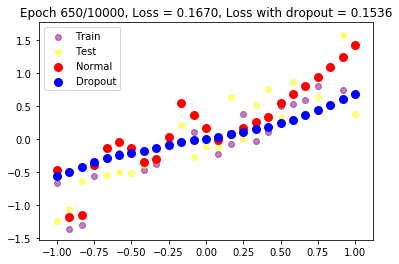

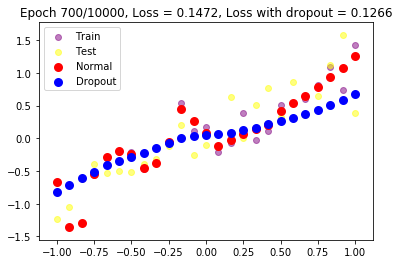

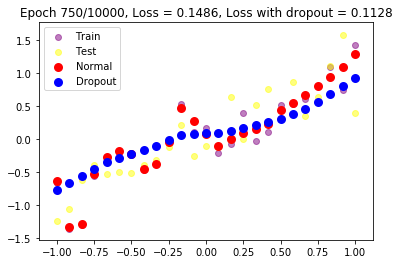

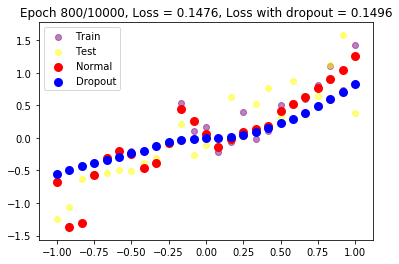

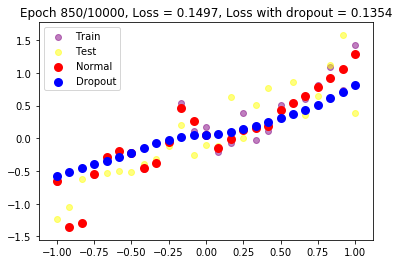

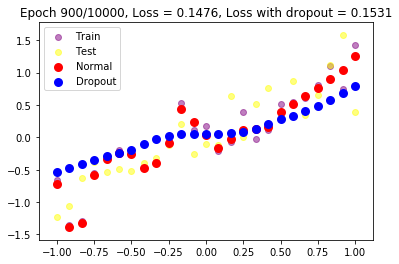

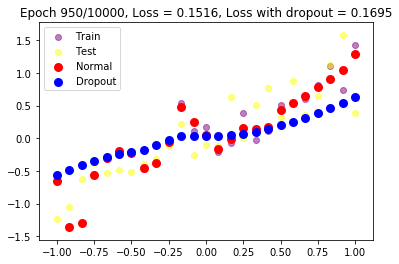

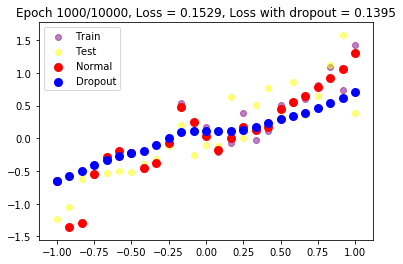

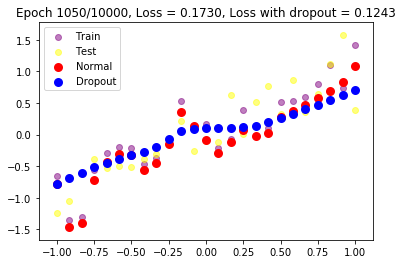

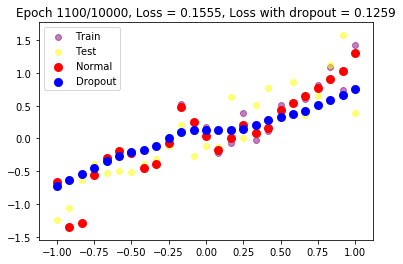

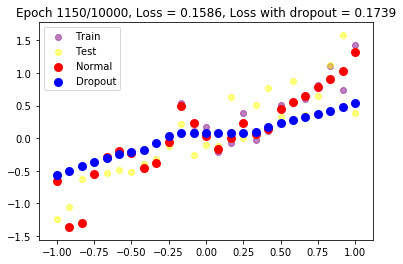

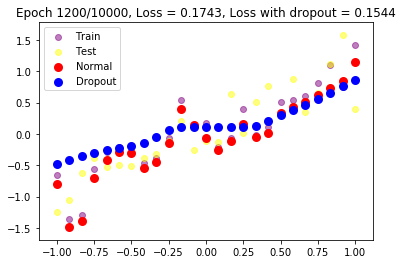

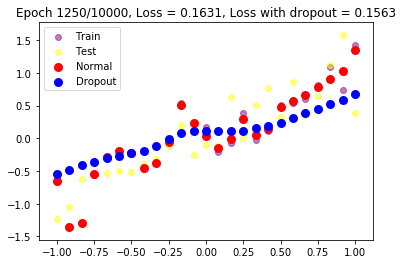

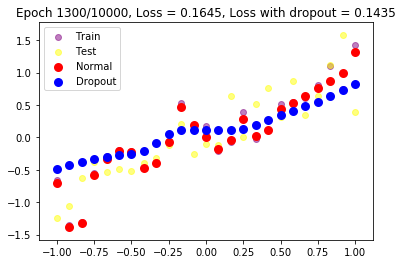

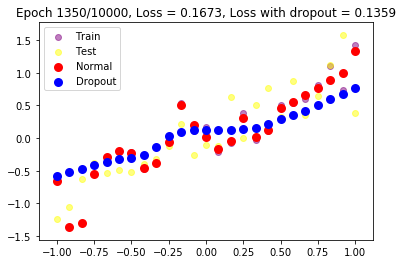

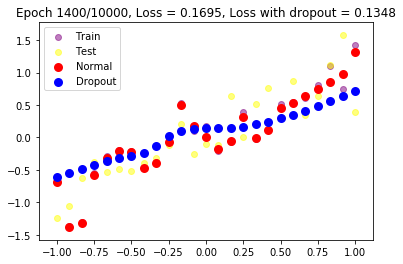

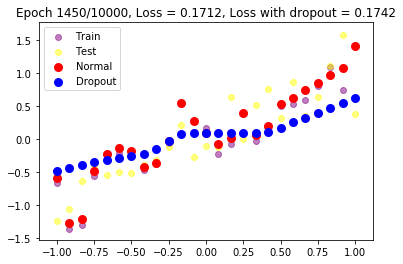

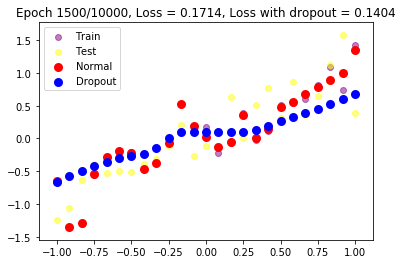

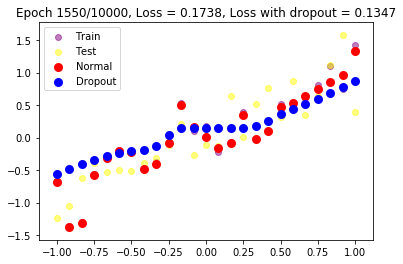

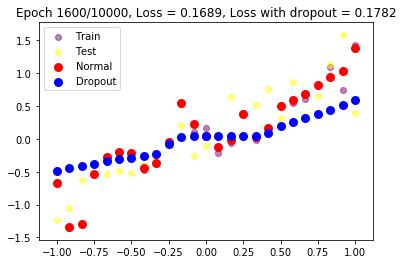

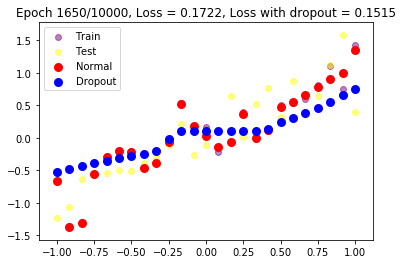

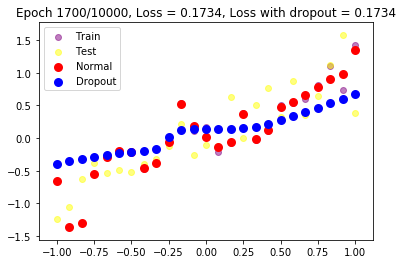

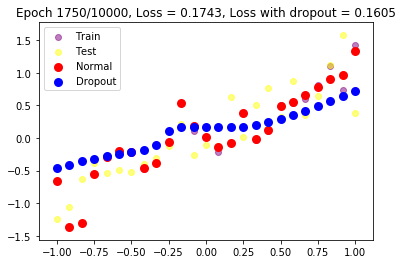

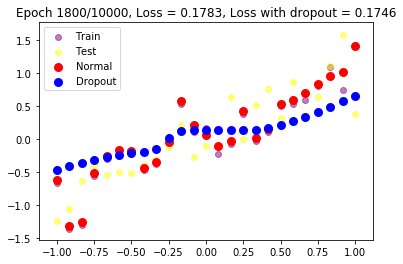

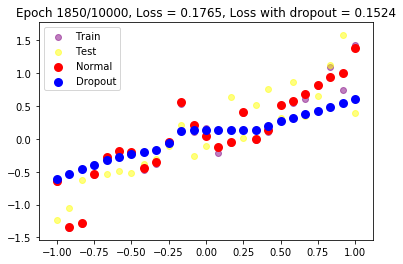

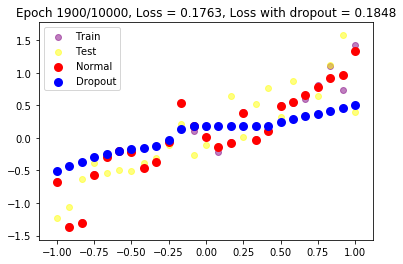

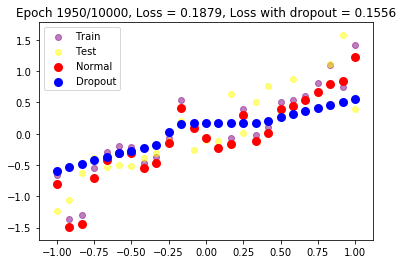

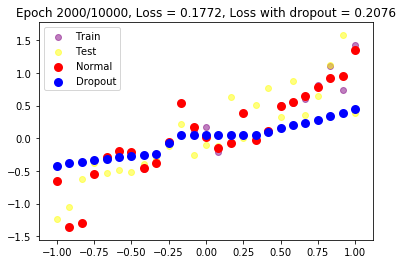

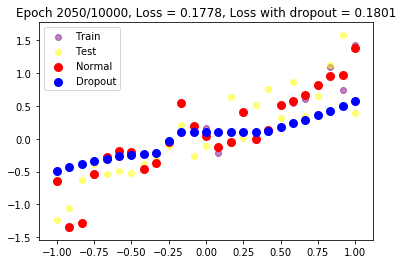

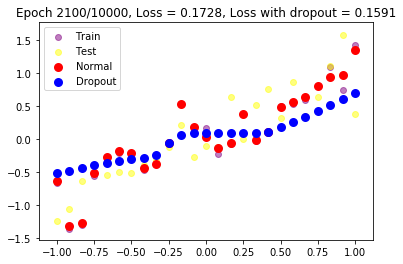

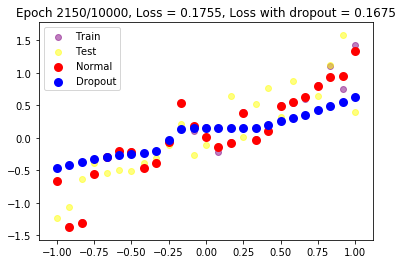

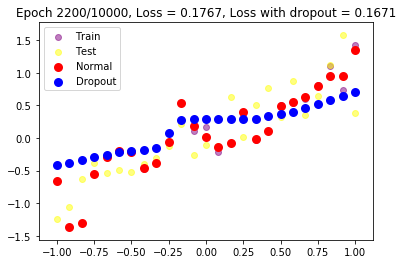

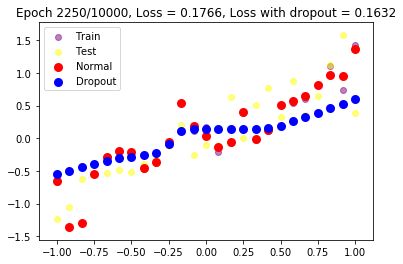

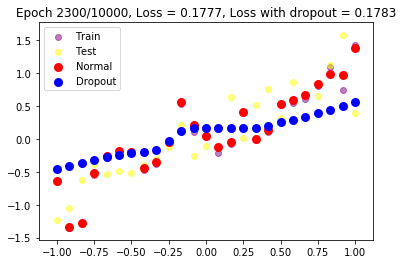

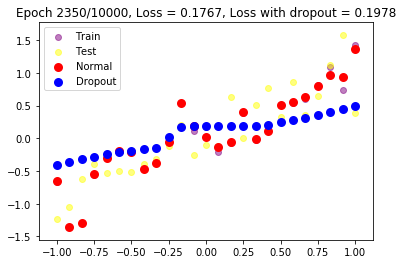

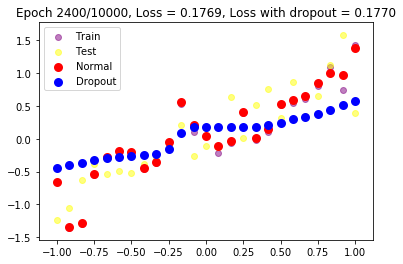

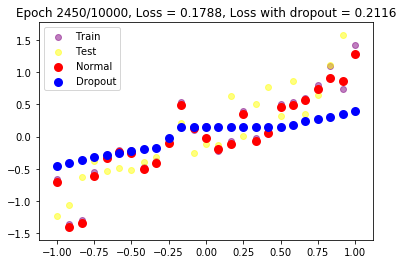

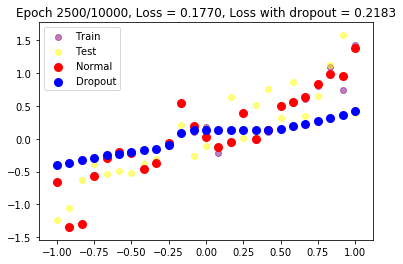

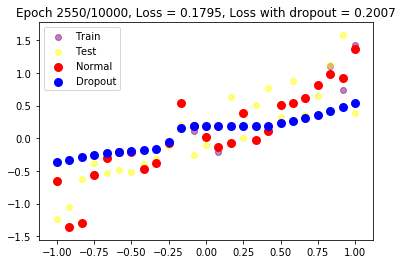

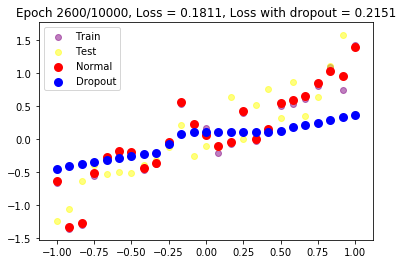

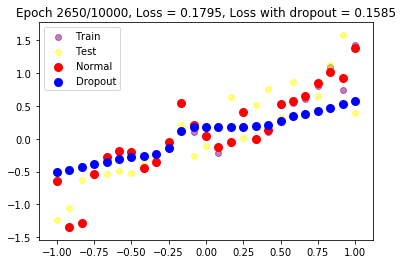

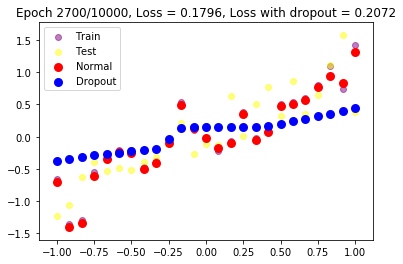

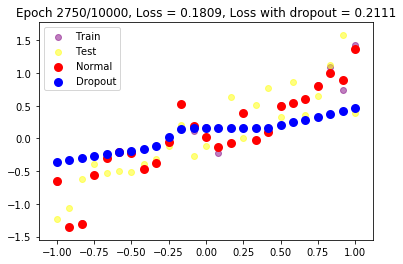

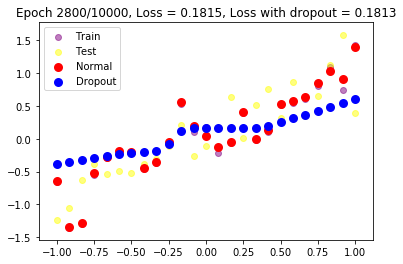

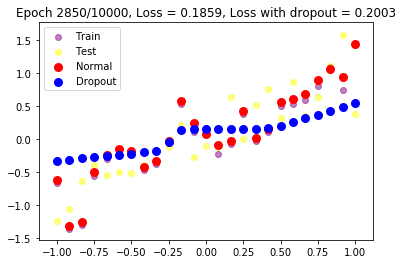

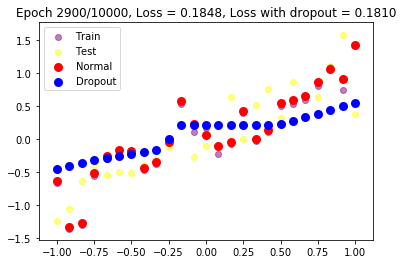

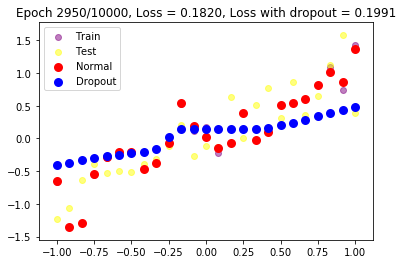

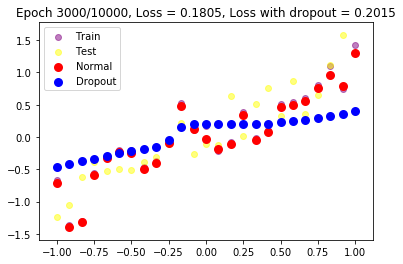

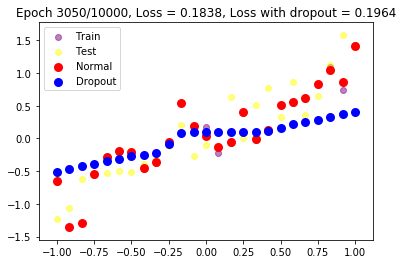

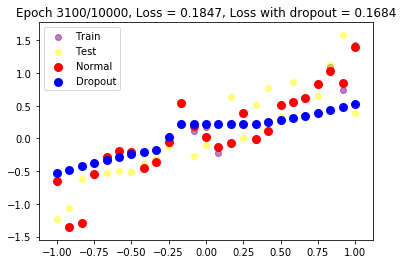

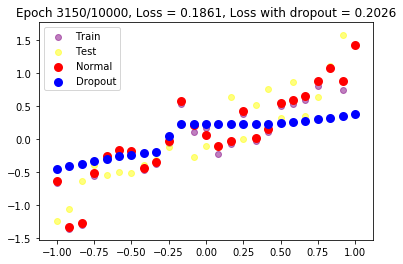

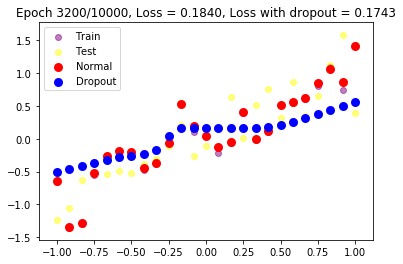

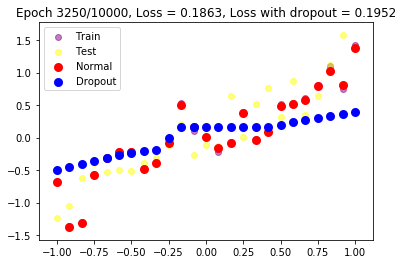

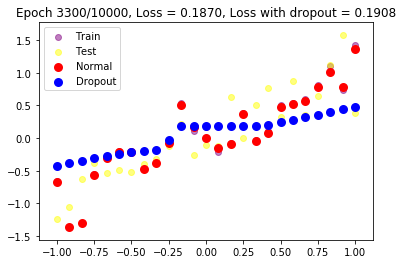

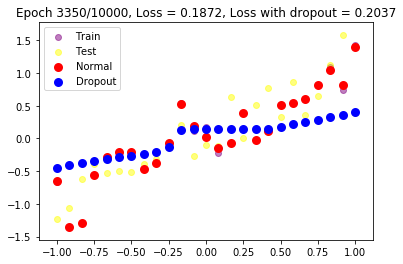

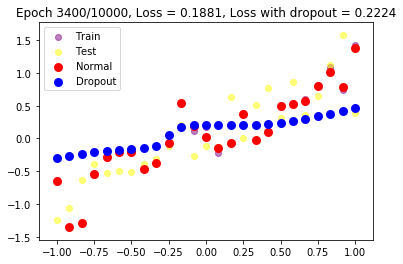

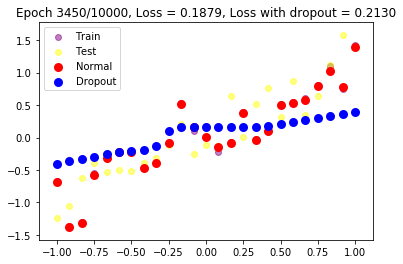

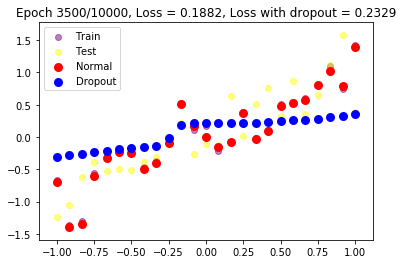

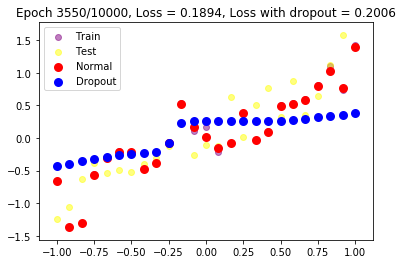

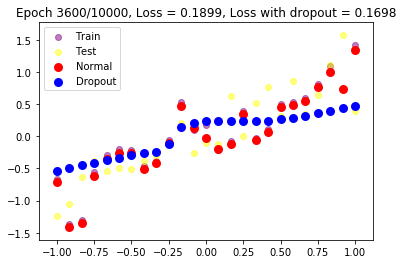

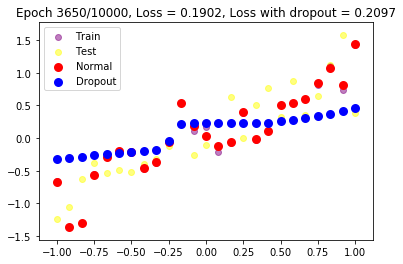

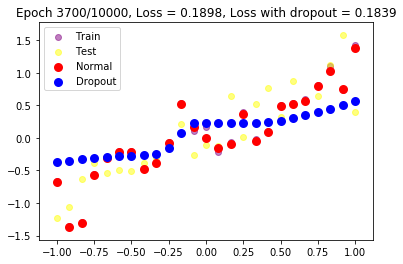

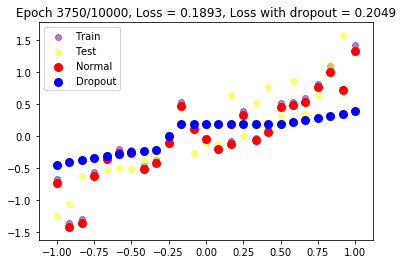

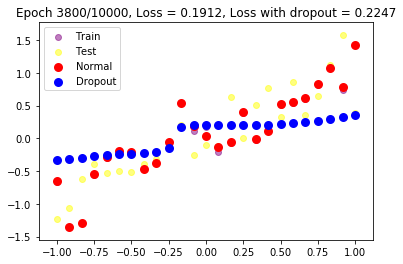

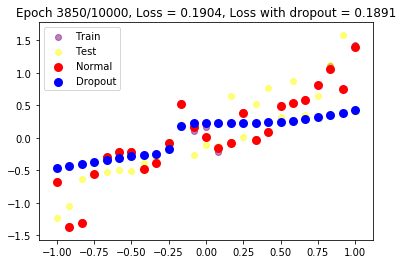

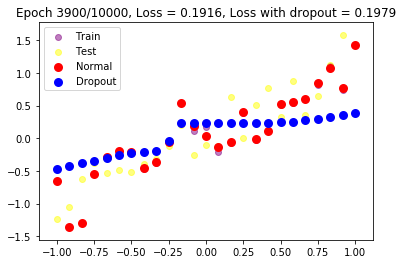

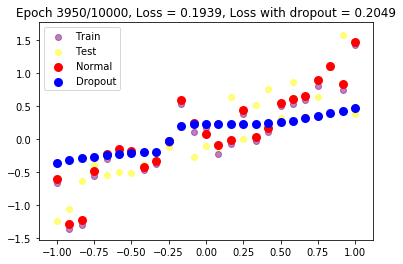

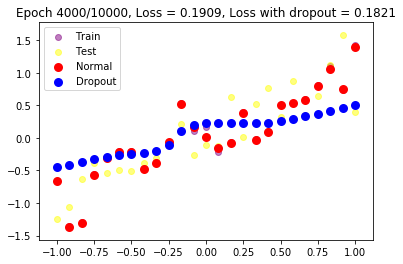

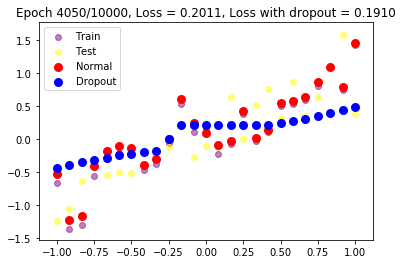

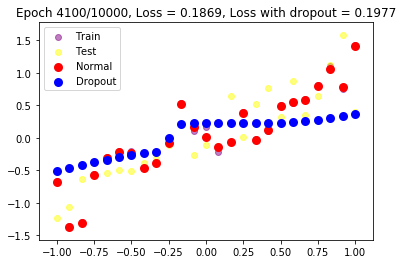

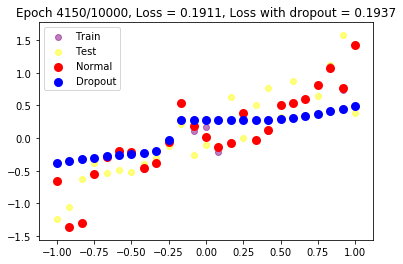

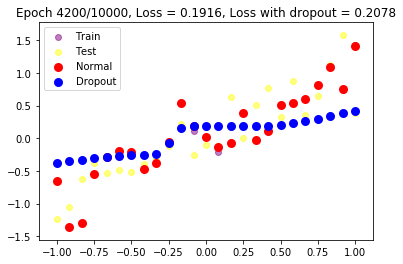

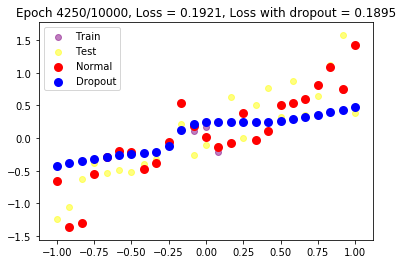

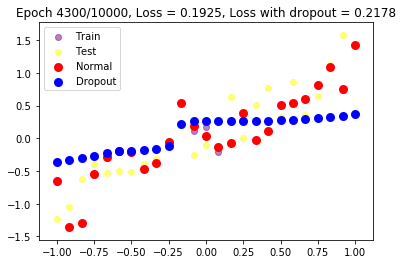

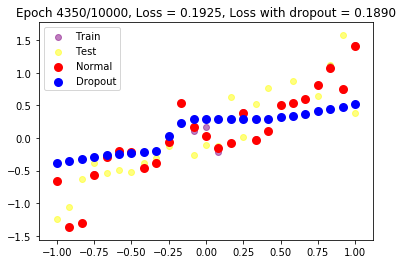

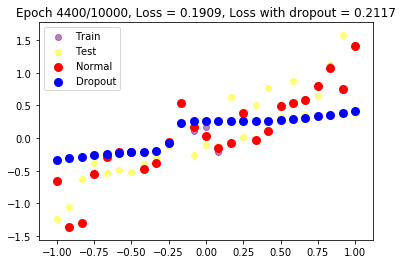

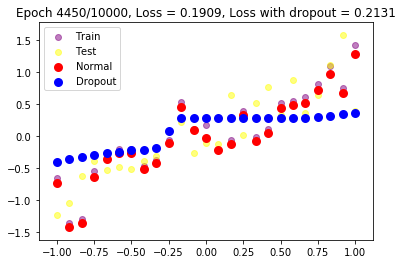

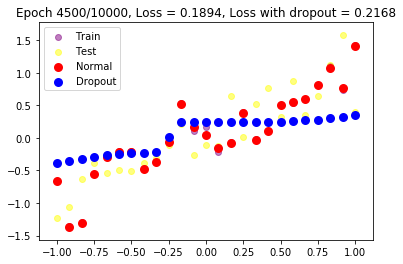

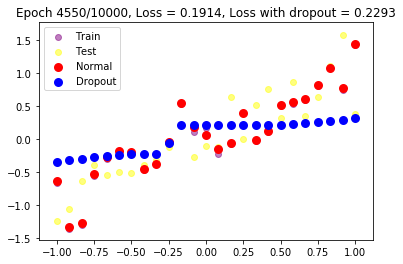

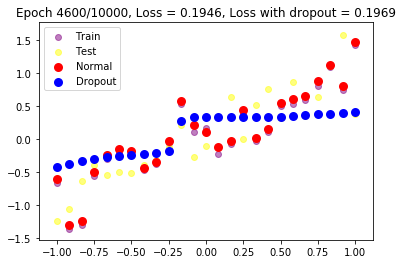

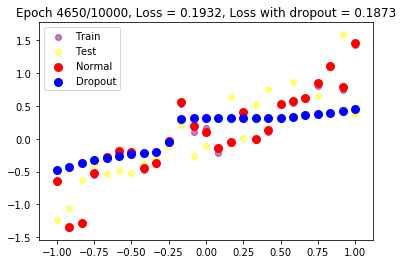

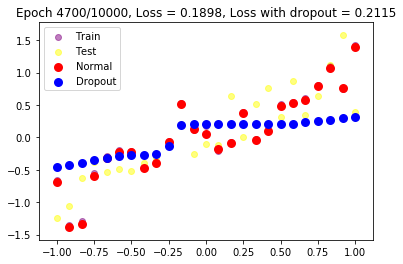

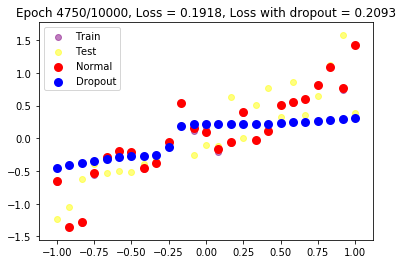

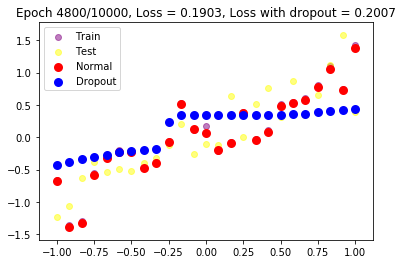

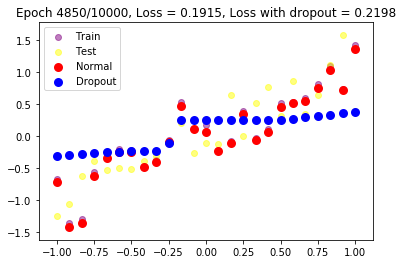

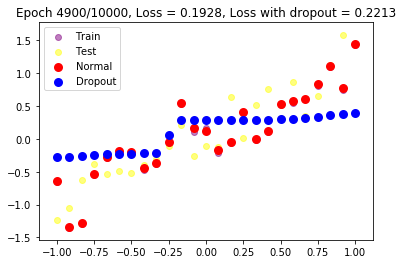

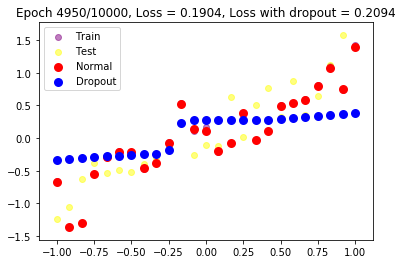

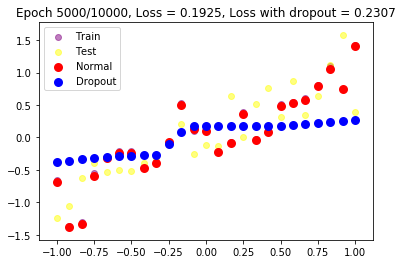

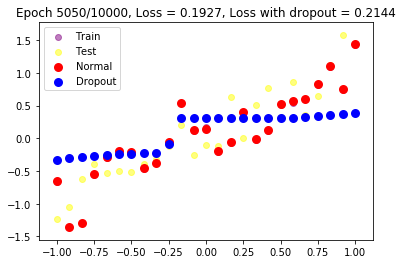

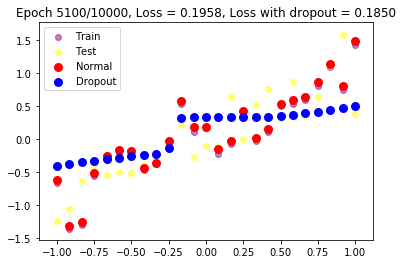

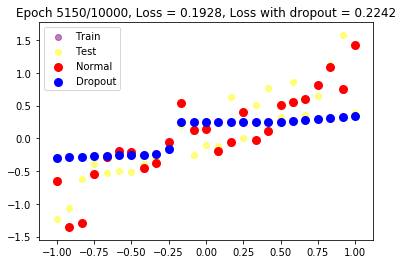

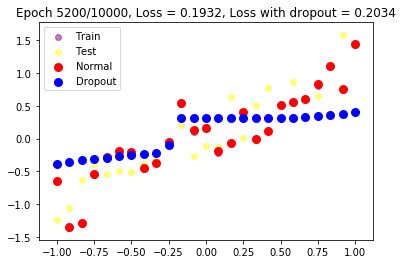

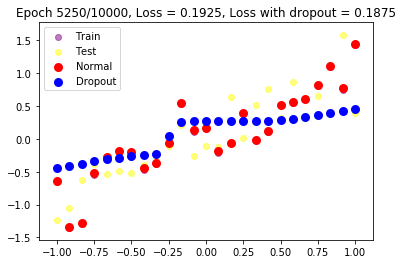

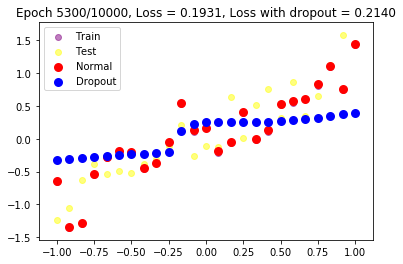

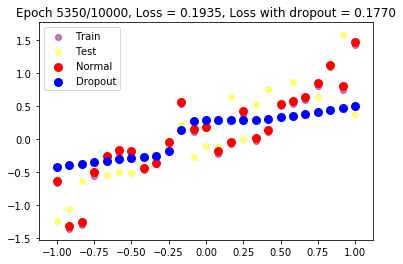

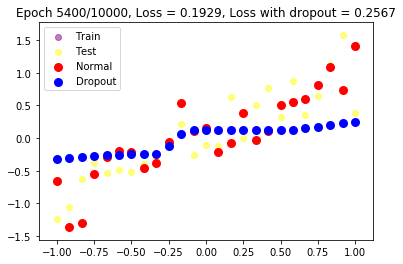

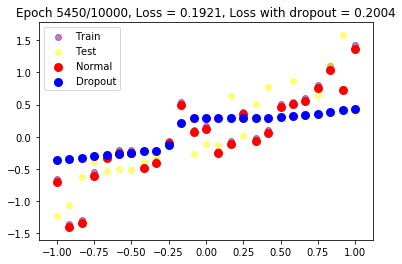

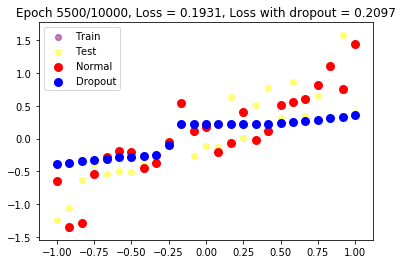

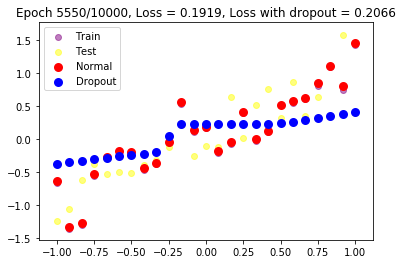

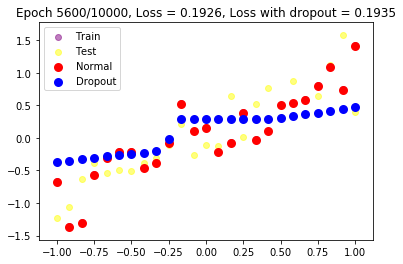

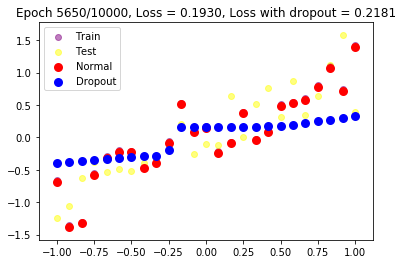

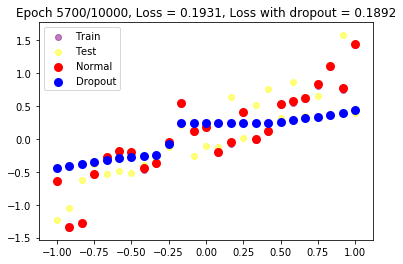

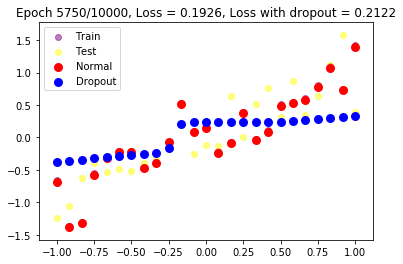

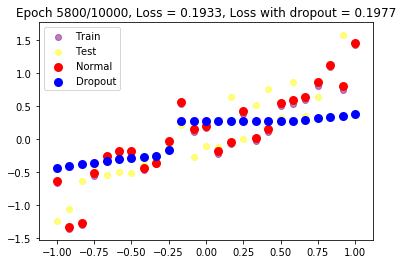

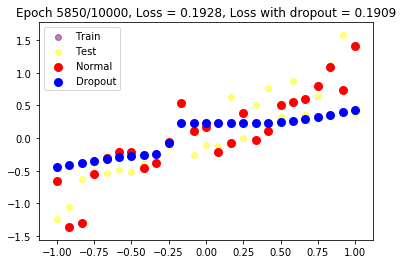

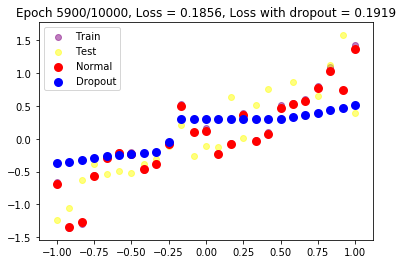

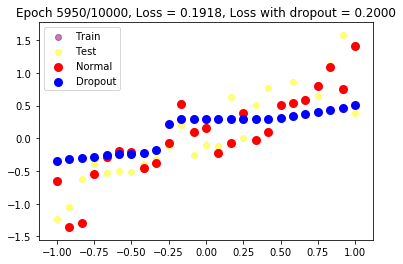

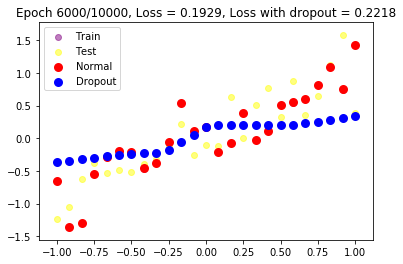

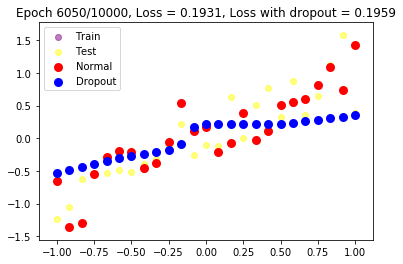

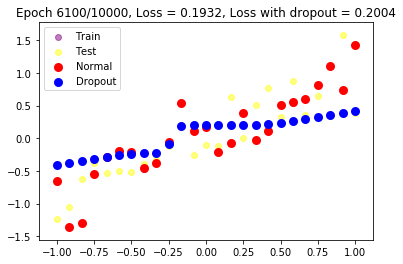

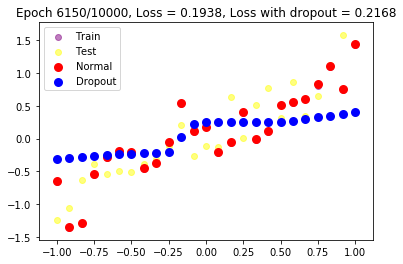

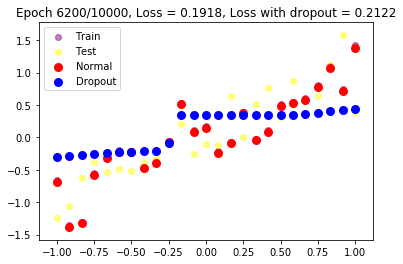

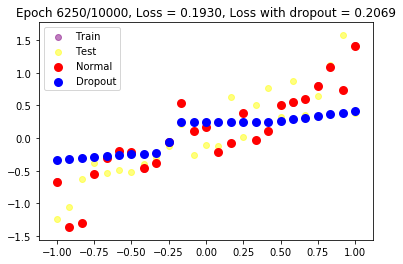

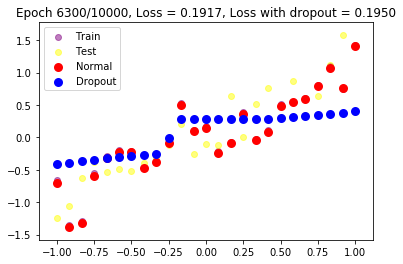

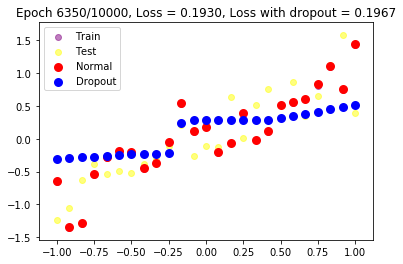

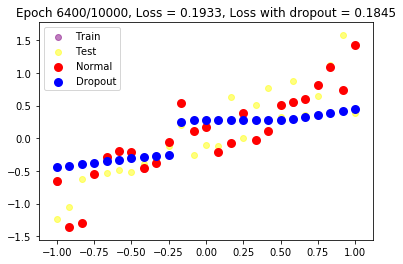

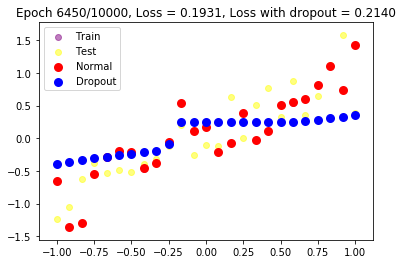

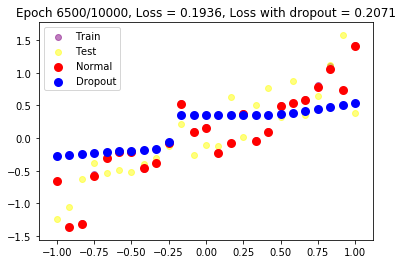

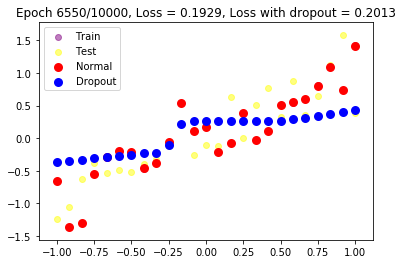

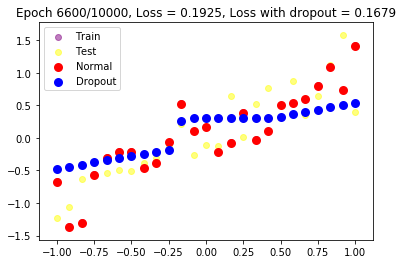

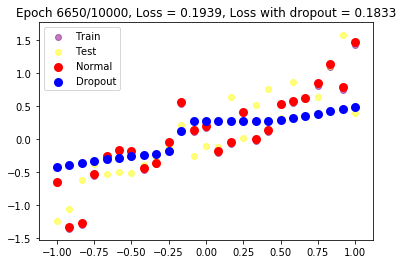

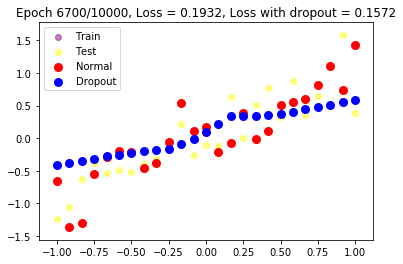

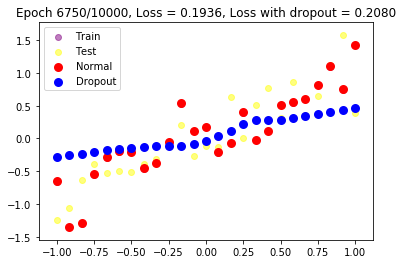

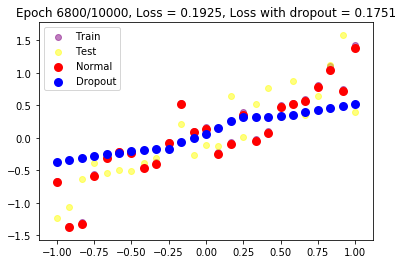

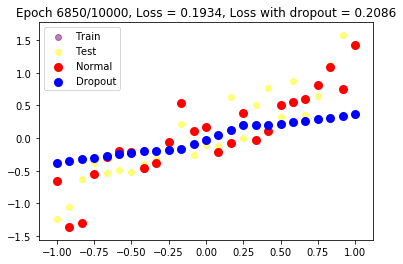

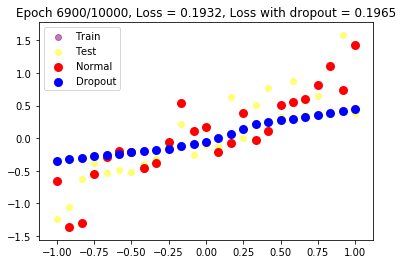

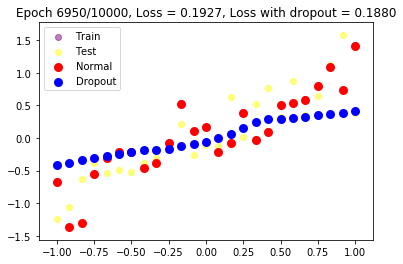

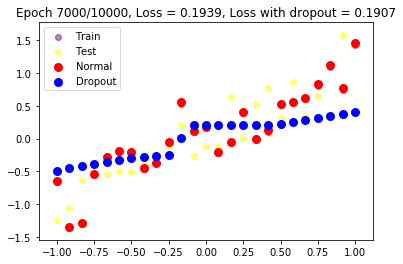

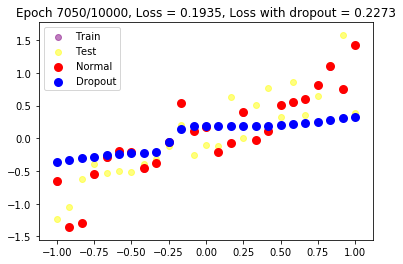

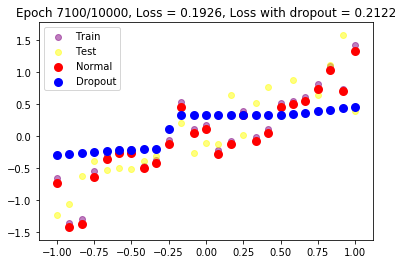

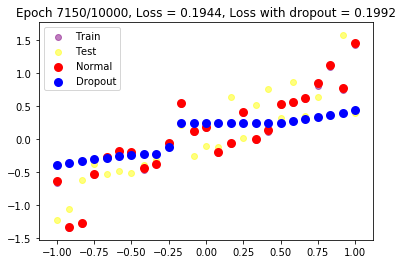

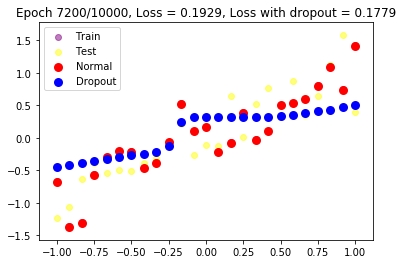

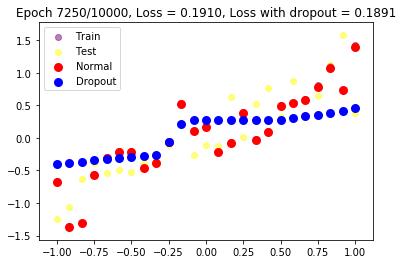

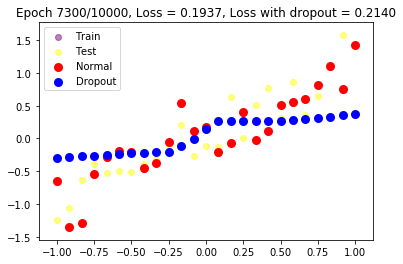

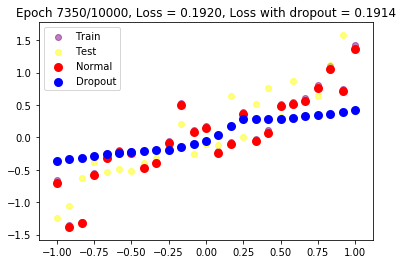

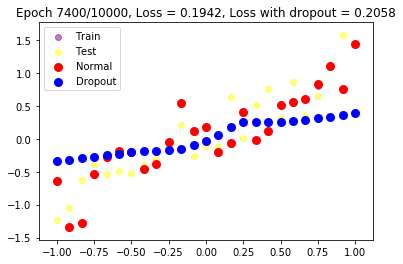

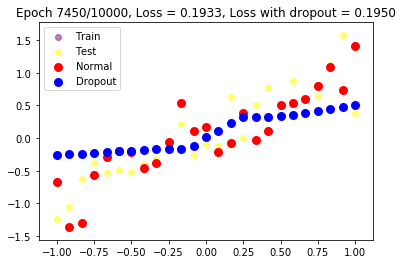

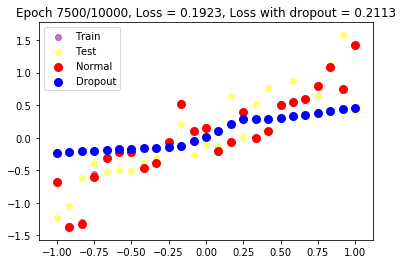

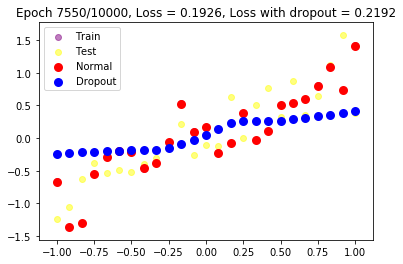

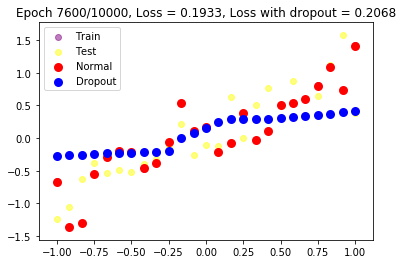

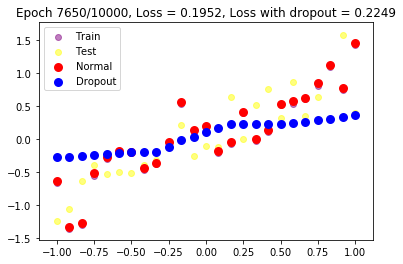

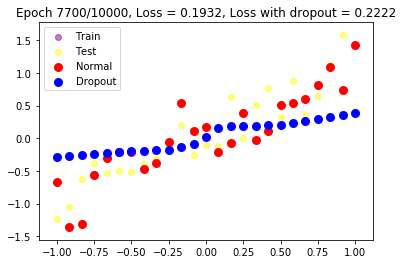

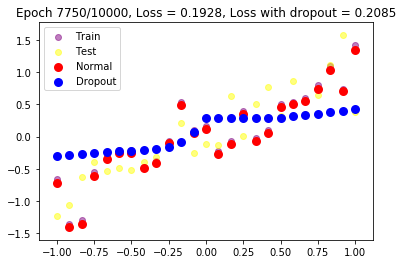

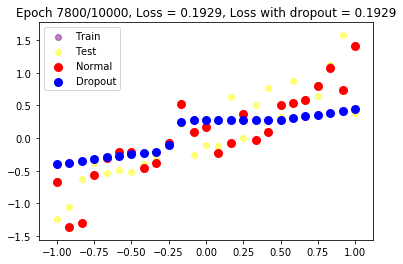

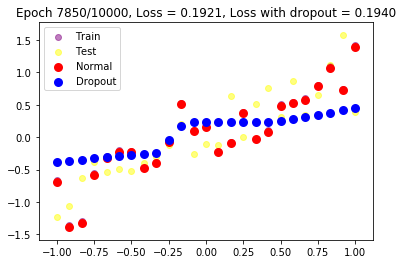

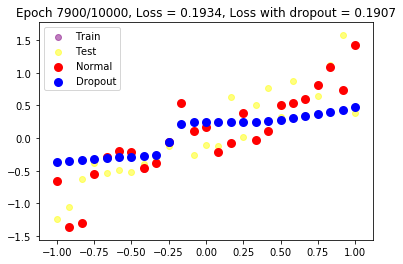

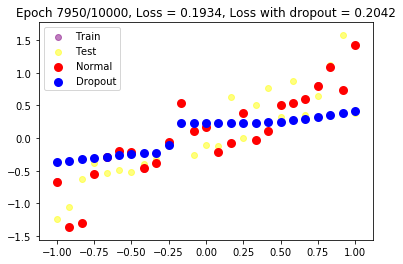

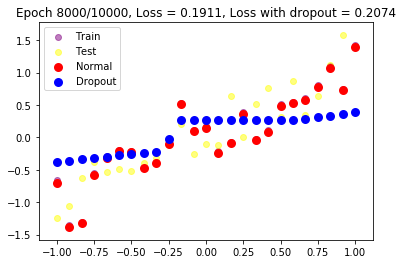

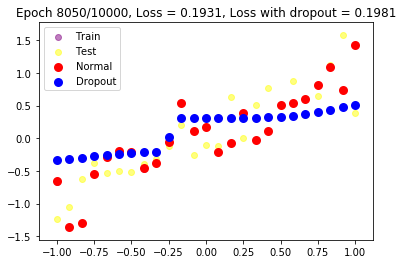

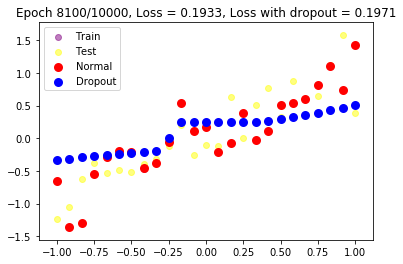

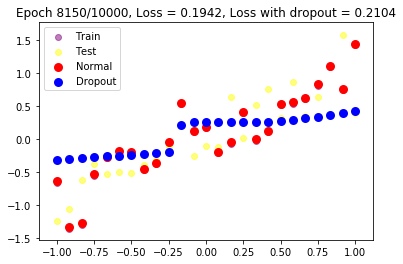

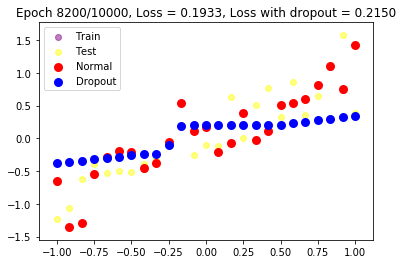

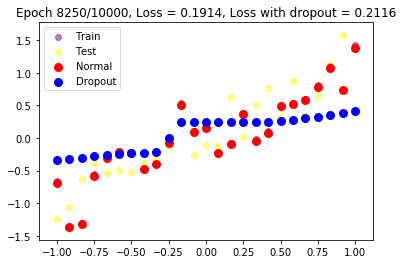

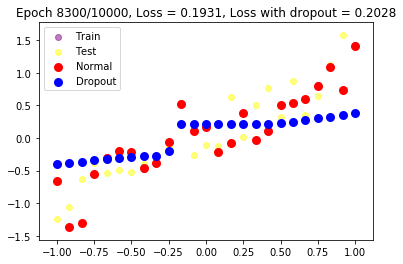

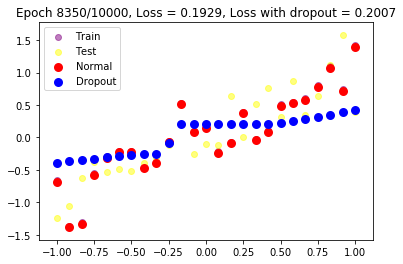

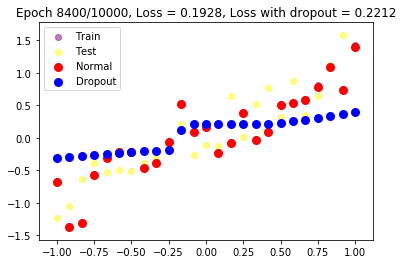

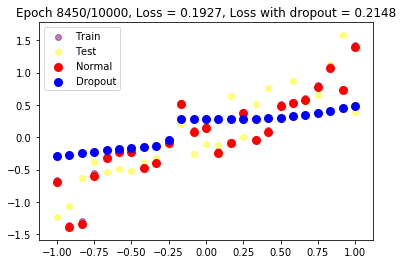

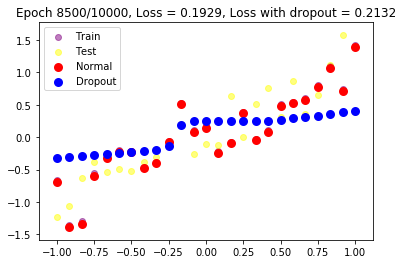

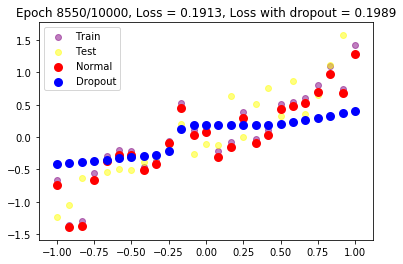

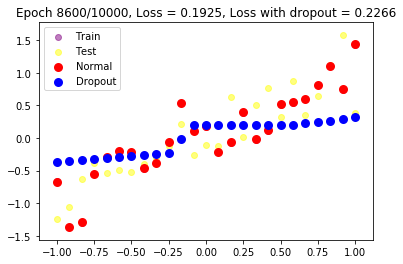

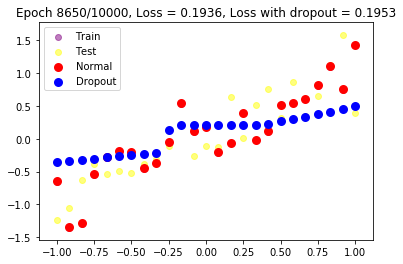

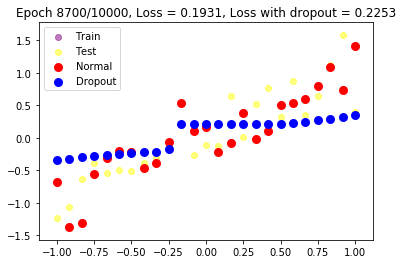

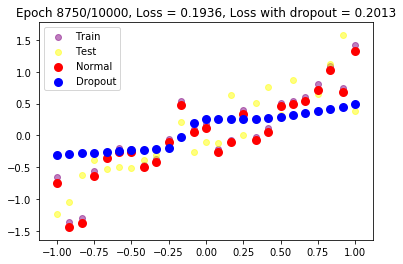

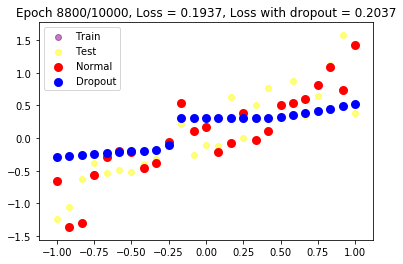

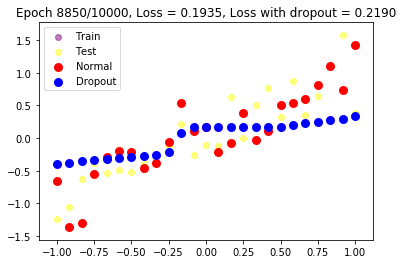

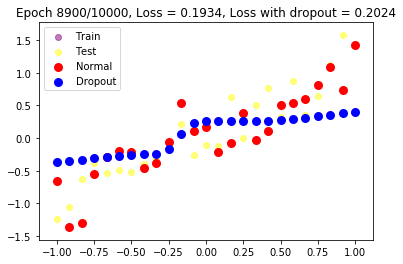

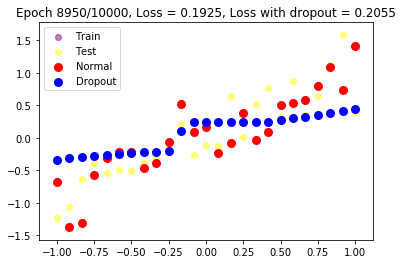

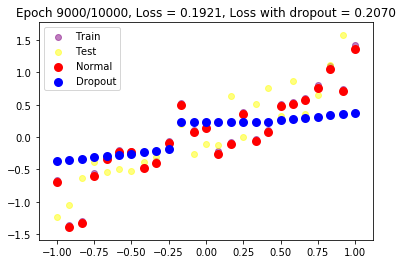

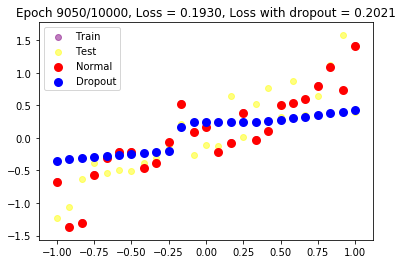

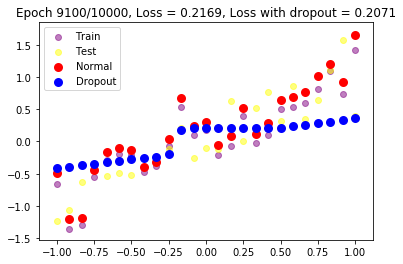

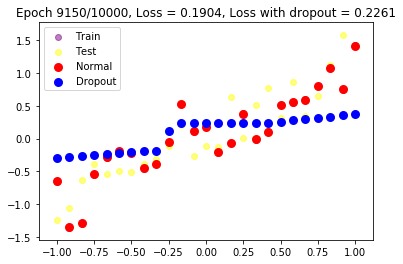

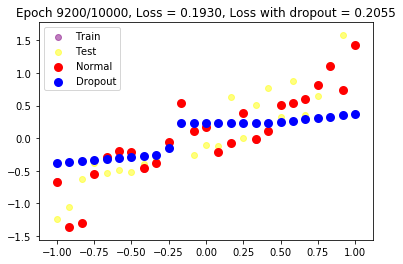

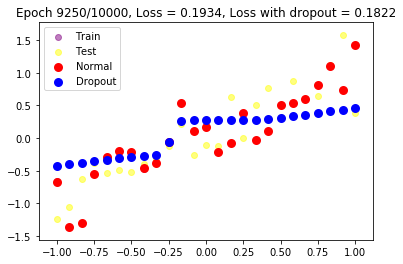

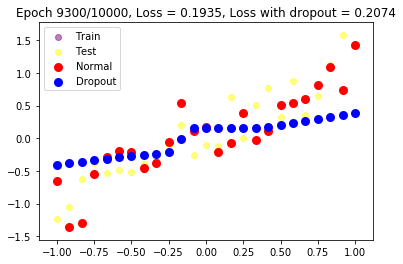

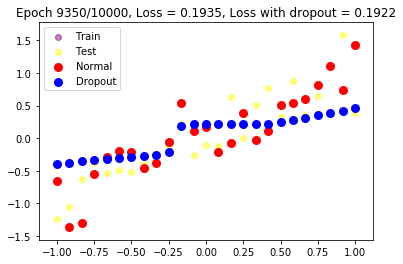

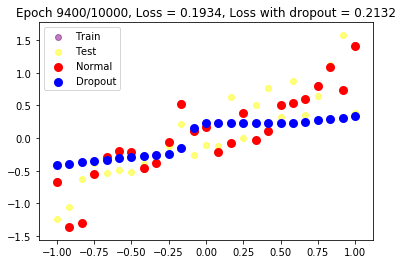

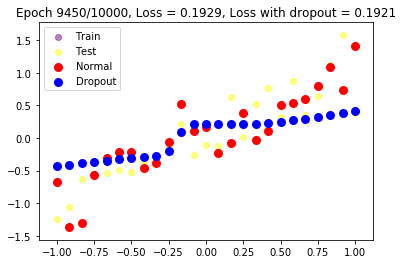

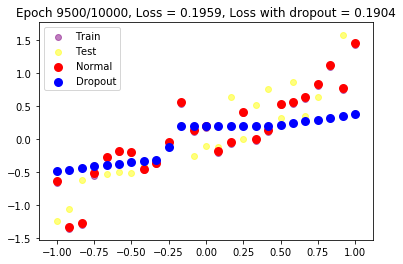

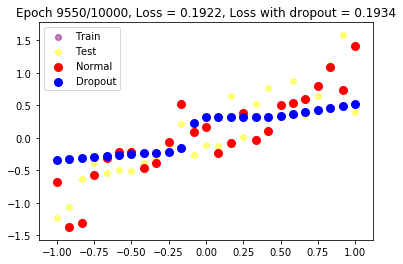

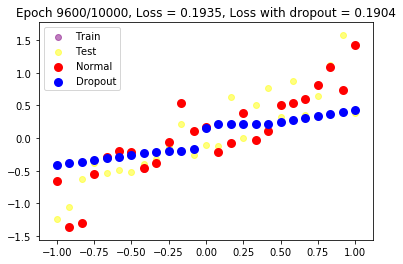

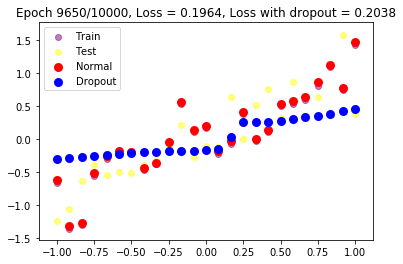

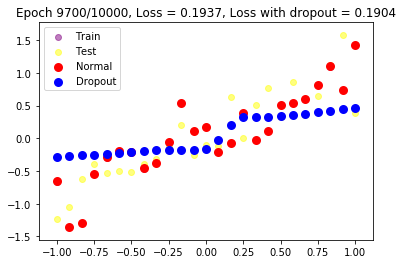

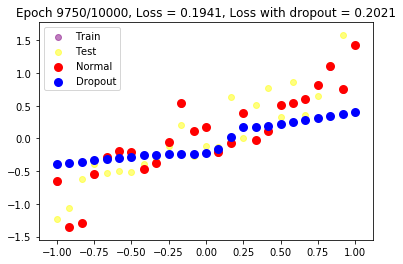

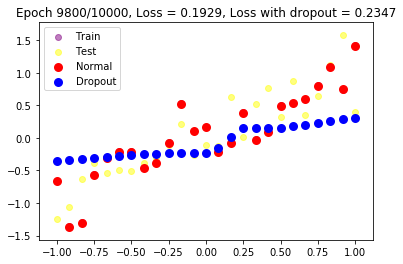

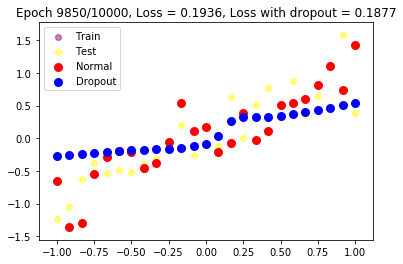

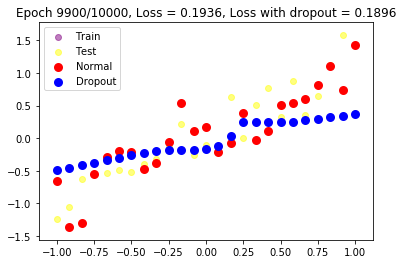

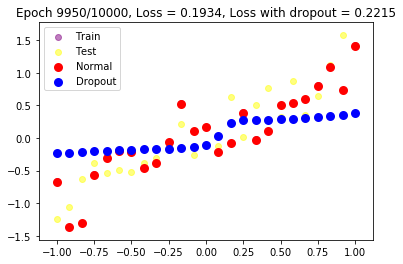

In [0]:
max_epochs = 10000

for epoch in range(max_epochs):
  pred = model(X_train)
  opt.zero_grad()
  
  loss = loss_fn(pred, Y_train)
  loss.backward()
  opt.step()
  
  pred_dropout = model_dropout(X_train)
  opt_dropout.zero_grad()
  
  loss_dropout = loss_fn(pred_dropout, Y_train)
  loss_dropout.backward()
  opt_dropout.step()
  
  if epoch%50 == 0:
    
    model.eval()
    model_dropout.eval()
    
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, Y_test)
    
    test_pred_dropout = model_dropout(X_test)
    test_loss_dropout = loss_fn(test_pred_dropout, Y_test)
    
    plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c="purple", alpha = 0.5, label="Train")
    plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c="yellow", alpha=0.5, label="Test")
    plt.scatter(X_test.data.numpy(), test_pred.data.numpy(), c="red", lw=3, label="Normal")
    plt.scatter(X_test.data.numpy(), test_pred_dropout.data.numpy(), c="blue", lw=3, label="Dropout")
    
    plt.title("Epoch %d/%d, Loss = %0.4f, Loss with dropout = %0.4f" % (epoch, max_epochs, test_loss, test_loss_dropout))
    
    plt.legend()
    plt.show()
    
    model.train()
    model_dropout.train()

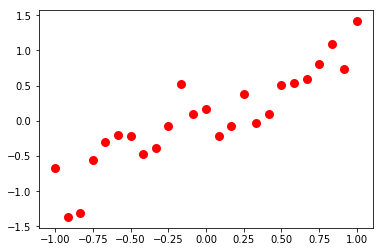

In [0]:
plt.scatter(X_test.data.numpy(), test_pred.data.numpy(),c='red', lw=3, label="Normal")